In [1]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
from tqdm.notebook import tqdm
from time import perf_counter_ns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve, LearningCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [3]:
df = pd.read_csv("datasets/predict+students+dropout+and+academic+success/data.csv", delimiter=";")

In [4]:
classes = df.Target.unique().tolist()

In [5]:
df.Target = df.Target.apply(lambda x: classes.index(x))

In [6]:
X = df.drop("Target", axis=1)
y = df.Target

In [7]:
X[X.columns] = MinMaxScaler().fit_transform(X)

In [8]:
SEED = 42
N_SPLITS = 10

In [9]:
def get_metrics(perf, time):
    result = {
        "precision": perf["weighted avg"]["precision"],
        "recall": perf["weighted avg"]["recall"],
        "f1-score": perf["weighted avg"]["f1-score"],
        "accuracy": perf["accuracy"],
        "time (ms)": time
    }
    return pd.DataFrame([result])

def train_and_evaluate(estimator, X_train, y_train, X_test, y_test):
    train_start = perf_counter_ns()
    estimator.fit(X_train, y_train)
    train_end = perf_counter_ns()
    train_time = (train_end - train_start)/1000000
    
    test_start = perf_counter_ns()
    y_test_pred = estimator.predict(X_test)
    test_end = perf_counter_ns()
    test_time = (test_end - test_start)/1000000
    
    y_train_pred = estimator.predict(X_train)
    train_perf = classification_report(y_train, y_train_pred, target_names=classes, output_dict=True)
    test_perf = classification_report(y_test, y_test_pred, target_names=classes, output_dict=True)
    report = {
        "test": get_metrics(test_perf, test_time),
        "train": get_metrics(train_perf, train_time),
    }
    return report

In [10]:
def mean_performance(results):
    mean = results.mean(axis=0).values
    return pd.DataFrame([mean], columns=results.columns)

In [11]:
def train_single_model(X, y, Clf, estimator_params):
    train_results, test_results = pd.DataFrame(), pd.DataFrame()

    split = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=0.3, random_state=SEED)
    for train_idx, test_idx in split.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        estimator = Clf(**estimator_params, random_state=SEED)
        report = train_and_evaluate(estimator, X_train, y_train, X_test, y_test)
        train_results = pd.concat([train_results, report["train"]], ignore_index=True)
        test_results = pd.concat([test_results, report["test"]], ignore_index=True)
    return train_results, test_results

In [12]:
def model_performance(X, y, Clf, params={}):
    train_res, test_res = train_single_model(X, y, Clf, params)
    train_res = mean_performance(train_res)
    test_res = mean_performance(test_res)
    print("Training Result")
    print(train_res.to_string(index=False), "\n")
    print("Testing Result")
    print(test_res.to_string(index=False))

In [13]:
def model_complexity(param_name, param_values, Clf, clf_name, data_name):
    train_f1, test_f1 = [], []
    for i in tqdm(param_values):
        clf_params = {param_name:i}
        train_res, test_res = train_single_model(X, y, Clf, clf_params)
        train_f1.append(mean_performance(train_res)["f1-score"][0])
        test_f1.append(mean_performance(test_res)["f1-score"][0])
    
    plot_data = pd.DataFrame({
        param_name:param_values,
        "Training F1-Score": train_f1,
        "Testing F1-Score": test_f1
    })
    
    sns.lineplot(x=param_name, y="Training F1-Score", data=plot_data, marker="o", label="Training Data")
    sns.lineplot(x=param_name, y="Testing F1-Score", data=plot_data, marker="o", label="Testing Data")
    plt.ylabel("F1-Score")

    plt.title(f"Model Complexity Plot of {clf_name} on {data_name}")
    plt.plot()
    plt.show()

In [26]:
def find_best_params(estimator, est_params, X, y, cv=10):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SEED)
    for train_idx, test_idx in split.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    clf = GridSearchCV(estimator=estimator(random_state=SEED), param_grid=est_params, scoring='f1_weighted', verbose=2, n_jobs=-1, cv=cv)
    clf.fit(X_train, y_train)
    best_params = {p:clf.best_params_[p] for p in est_params}
    return best_params

In [15]:
def single_lc_plot(sizes, train, test, score_name):
    fig, ax = plt.subplots()
    display = LearningCurveDisplay(train_sizes=sizes, train_scores=train, test_scores=test)
    display.plot(ax, score_name=score_name, score_type="both", line_kw={"marker":"o"})
    plt.show()

In [29]:
def learning_curve_plot(Clf, clf_params, cv):
    data_sizes = np.linspace(0.1, 1, 20)
    clf = Clf(**clf_params, random_state=SEED)
    scores = learning_curve(clf, X, y, train_sizes=data_sizes, cv=cv, scoring="f1_weighted", return_times=True)

    single_lc_plot(scores[0], scores[1], scores[2], "f1_weighted")

    single_lc_plot(scores[0], scores[3], scores[4], "time (s)")

In [30]:
def perform_analysis(X, y, data_name, Clf, clf_name, complexity_params, params_grid, cv=10):
    print(f"Performance of {clf_name} on {data_name} with default parameters:\n")
    model_performance(X, y, Clf)
    print()
    
    if complexity_params:
        print("Calculating Model Complexity vs Score.")
        model_complexity(**complexity_params, Clf=Clf, clf_name=clf_name, data_name=data_name)
        print("Done Calculating Model Complexity vs Score.\n")

    if not params_grid: return
    
    print(f"Finding best parameters for {clf_name} on {data_name}.\n")
    best_params = find_best_params(Clf, params_grid, X, y, cv=cv)
    print(f"Done Finding best parameters for {clf_name} on {data_name}.\n")
    
    print(f"Best Parameters for {clf_name} on {data_name}\n{best_params}\n")

    print(f"Performance of {clf_name} on {data_name} with best parameters:\n")
    model_performance(X, y, Clf, best_params)

    learning_curve_plot(Clf, best_params, cv)

Performance of Decision Tree on Student Dataset with default parameters:

Training Result
 precision  recall  f1-score  accuracy  time (ms)
       1.0     1.0       1.0       1.0   22.81383 

Testing Result
 precision   recall  f1-score  accuracy  time (ms)
   0.68519 0.679443  0.681997  0.679443    0.99268

Calculating Model Complexity vs Score.


  0%|          | 0/25 [00:00<?, ?it/s]

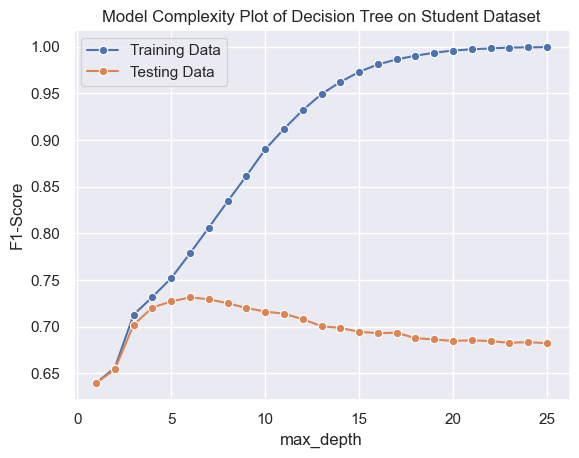

Done Calculating Model Complexity vs Score.

Finding best parameters for Decision Tree on Student Dataset.
Done Finding best parameters for Decision Tree on Student Dataset.

Best Parameters for Decision Tree on Student Dataset
{'max_depth': 6, 'min_samples_split': 1, 'min_samples_leaf': 5}

Performance of Decision Tree on Student Dataset with best parameters:

Training Result
 precision   recall  f1-score  accuracy  time (ms)
  0.780025 0.785627  0.773205  0.785627   10.74017 

Testing Result
 precision   recall  f1-score  accuracy  time (ms)
  0.735277 0.746837  0.732306  0.746837    0.85964


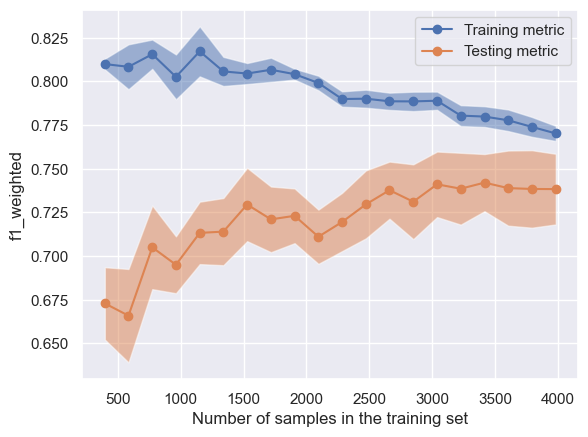

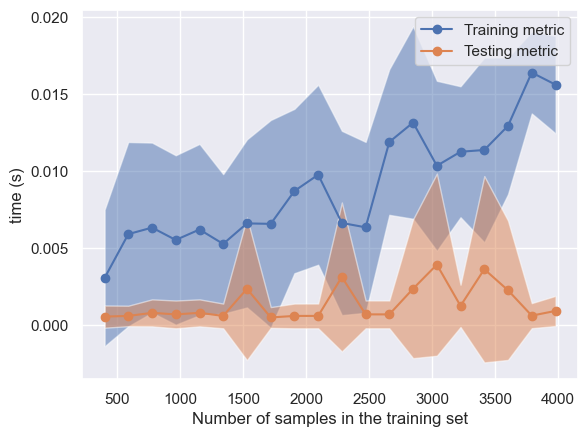

In [27]:
data_name = "Student Dataset"
Clf = DecisionTreeClassifier
clf_name = "Decision Tree"
clf_complexity_params = {"param_name":"max_depth", "param_values": range(1, 26)}
clf_params_grid = {
    "max_depth": range(1, 11),
    "min_samples_split": range(1, 11),
    "min_samples_leaf": range(1, 11)
}

perform_analysis(X, y, data_name, Clf, clf_name, clf_complexity_params, clf_params_grid)

In [ ]:
# data_name = "Student Dataset"
# Clf = MLPClassifier
# clf_name = "Neural Network"
# clf_complexity_params = {"param_name":"hidden_layer_sizes", "param_values": range(1, 101, 5)}
# clf_params_grid = {
#     "hidden_layer_sizes": range(1, 11),
#     "max_iter": range(100, 1000, 10),
#     "learning_rate_init": [0.0001, 0.0005, 0.001, 0.005, 0.01]
# }

# perform_analysis(X, y, data_name, Clf, clf_name, clf_complexity_params, clf_params_grid)

Performance of Gradient Boosting on Student Dataset with default parameters:

Training Result
 precision   recall  f1-score  accuracy  time (ms)
  0.844959 0.847481  0.841896  0.847481 1744.11996 

Testing Result
 precision   recall  f1-score  accuracy  time (ms)
   0.76209 0.773795  0.762415  0.773795    6.29942

Calculating Model Complexity vs Score.


  0%|          | 0/20 [00:00<?, ?it/s]

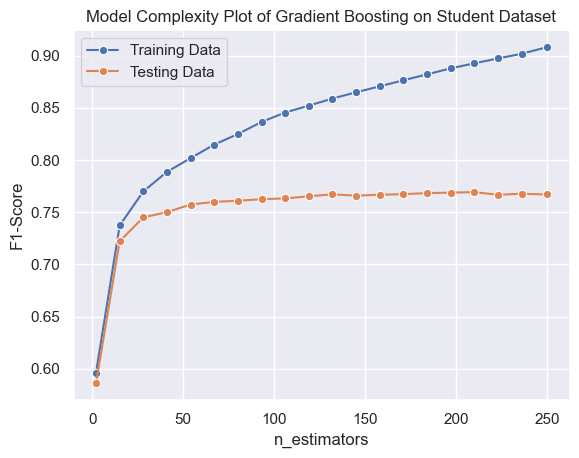

Done Calculating Model Complexity vs Score.

Finding best parameters for Gradient Boosting on Student Dataset.

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Done Finding best parameters for Gradient Boosting on Student Dataset.

Best Parameters for Gradient Boosting on Student Dataset
{'n_estimators': 210, 'min_samples_split': 1, 'min_samples_leaf': 7}

Performance of Gradient Boosting on Student Dataset with best parameters:

Training Result
 precision  recall  f1-score  accuracy  time (ms)
  0.894786 0.89438  0.891793   0.89438 3693.92396 

Testing Result
 precision   recall  f1-score  accuracy  time (ms)
  0.763896 0.775151  0.765164  0.775151    11.4824


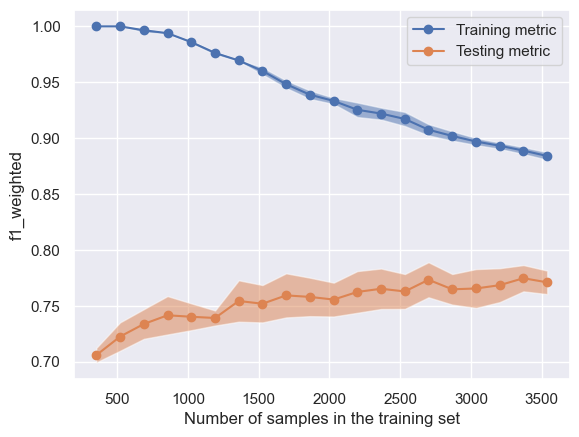

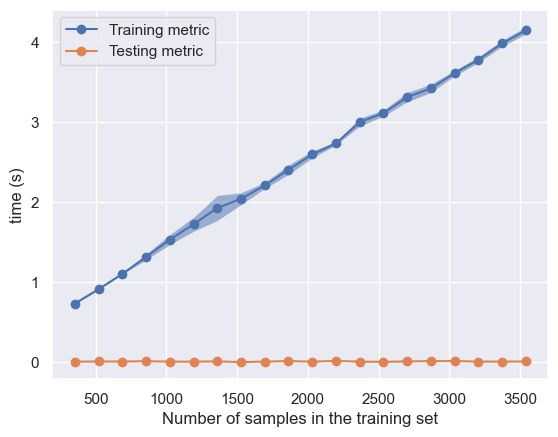

In [31]:
N_SPLITS = 5

data_name = "Student Dataset"
Clf = GradientBoostingClassifier
clf_name = "Gradient Boosting"
clf_complexity_params = {"param_name":"n_estimators", "param_values": np.linspace(2, 250, 20, dtype=np.int64)}
clf_params_grid = {
    "n_estimators": np.linspace(2, 250, 20, dtype=np.int64),
    "min_samples_split": range(1, 11),
    "min_samples_leaf": range(1, 11)
}

perform_analysis(X, y, data_name, Clf, clf_name, clf_complexity_params, clf_params_grid, cv=5)

N_SPLITS = 10